In [1]:
# load the required libraries
import scipy # to calculate correlation
import pandas as pd # to use dataframe
import seaborn as sns # to make plots
import matplotlib.pyplot as plt # to make plots
import numpy as np
from sklearn.metrics import mean_absolute_error # to calculate MAE
from sklearn.model_selection import train_test_split, KFold # to create data splits
from scipy import stats

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import joblib

from pathlib import Path
import os

import datetime

In [3]:
#### Define the conditions for which the analysis should run

## Define Time point
#time = 'Base'
time = '2yFU'
#time = '4yFU'

### cortical thickness data:
input_type = 'cortical_thickness_Desikan'
#input_type = 'cortical_thickness_Destrieux'


## define whether the analysis is performed for the whole group, only boys or only girls:
group = 'whole_group'
#group = 'only_boys'
#group = 'only_girls'

## define target variable:
#target = 'PhSeAbuse'
#target = 'NHT'
#target = 'PreSubExp'
target = 'HD'
#target = 'Scarcity'
#target = 'ParentPsych'
#target = 'SESrec'
#target = 'INR'


## define confounding variable:
#confound = 'ICV'
confound = 'None'

## define analysis type:
analysis_type = 'scikit_learn'
#analysis_type = 'Julearn'


#number of repetitions you want to perform for the predictive models in the null-distributions:
rep_null = 1000


# type of shuffling for the null-distribution:
#shuffling_type = 'overall_shuffling'
shuffling_type = 'shuffling_per_site'

In [4]:
### define local data directory:

# define local data directory:
ABCD_data_directory = '/Users/kbrosch/Desktop/ABCD analyses'

results_directory = '/Users/kbrosch/Desktop/ML'

### define new folder in results-directory:

foldername = f"abcd_UniqueSample_{target}_PredictAll_{time}_{group}_{input_type}"

full_path = os.path.join(results_directory,foldername)


In [5]:
# load data created in previous skript for the ML analysis:

X = pd.read_csv(full_path + '/input_X.csv')

y = pd.read_csv(full_path + '/input_y.csv')

sites = pd.read_csv(full_path + '/input_sites.csv')

y_applied = pd.read_csv(full_path +  '/input_y_applied.csv')


In [6]:
#Baseline rec
#y_applied_datanames= ['PhSeAbuse','NHT', 'PreSubExp', 'HD', 'Scarcity', 'ParentPsych', 'SESrec']
#n_y_applied = y_applied.shape[1]

#with inr
#y_applied_datanames= ['PhSeAbuse','NHT', 'PreSubExp', 'HD', 'Scarcity', 'ParentPsych', 'SESrec','INR']
#n_y_applied = y_applied.shape[1]

#2yFU
y_applied_datanames= ['PhSeAbuse','NHT', 'HD', 'SESrec']
n_y_applied = y_applied.shape[1]

#4yFU
#y_applied_datanames= ['NHT', 'HD', 'SESrec']
#n_y_applied = y_applied.shape[1]


In [7]:
# recheck numbers of the sites:
unique_values_sites = np.unique(sites)
unique_values_sites

counts_values_sites = sites.value_counts()
counts_values_sites


site_id_l
site16       404
site10       290
site04       281
site20       277
site17       268
site13       232
site06       216
site14       216
site12       214
site21       180
site11       175
site07       168
site03       150
site18       144
site15       143
site02       134
site01       133
site19       129
site05       128
site09       122
site08        82
Name: count, dtype: int64

In [8]:
total_sample_size = len(sites)
print("Sample size")
total_sample_size

Sample size


4086

In [9]:
#number of features
#n_feat = X.shape[1]

#create variables to store relevant data/outputs
#r^2 - coefficient of determination
r2_scores_list_null_distribution = np.zeros([n_y_applied, rep_null])

#explained variance
explained_variance_list_null_distribution = np.zeros([n_y_applied, rep_null])

#correlation between true and predicted values -> prediction accuracy
corr_coeff_list_pearson_null_distribution = np.zeros([n_y_applied, rep_null])
corr_p_value_list_pearson_null_distribution = np.zeros([n_y_applied, rep_null])

#optimised alpha (hyperparameter)
#opt_alpha = []

#feature importance extracted from the model
#feature_names = X.columns
#feat_imp = pd.DataFrame(columns=feature_names)

In [10]:
for p in range(rep_null):

    #print model you're on
    print('Model %d' %(p+1))

    
    # Now you can use datetime functionalities
    current_time = datetime.datetime.now()
    print("Current Date and Time ",current_time)
    
          
    ## either shuffle the target variable over the whole population or shuffle within each site:
        
    # shuffle all of y over the overall population:
    if shuffling_type == 'overall_shuffling':
        y_shuffle = shuffle(y, random_state=p)
        
   
        X_null_distribution = X
        y_null_distribution = y_shuffle
    
    # Iteration thorugh all sites to shuffle per site:
    elif shuffling_type == 'shuffling_per_site':
    
    # Create a new empty dataframe with the same Dimensions as y:
        y_shuffled = pd.DataFrame(index=range(y.shape[0]), columns=range(y.shape[1]))
    
        # iterate through all sites and shuffle per site:
        for site_number in unique_values_sites:
            #print(f"Working on: {site_number}")
    
            # create a logical index that includes only the entries of the current site in the for-loop:
            logical_index_site = sites['site_id_l'] == site_number
    
            count_true = np.count_nonzero(logical_index_site)
            #print(f"Number of entries in {site_number}: {count_true}")
    
            y_shuffled.loc[logical_index_site] = np.random.permutation(y.loc[logical_index_site])

            X_null_distribution = X
            y_null_distribution = y_shuffled
            
    
    #### from here is the same code as in the predictive modeling code:
    
    ### split data into training and test:
    
    # generate a single division (by using the next function) of the data X into training and test sets, with all data belonging to the same group site 
    # ending up either completely in the training set or in the test set. The indices of these data points are then stored 
    # in the variables train_inds and test_inds.
    train_indx, test_indx = next(GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = p).split(X_null_distribution, groups=sites))
    
    # use .iloc[] to enable access to the rows of the DataFrame via the indices that were created with GroupShuffleSplit.
    X_train = X_null_distribution.iloc[train_indx]
    X_test = X_null_distribution.iloc[test_indx]
    
    y_train = y_null_distribution.iloc[train_indx]
    #y_test = y_null_distribution.iloc[test_indx]
    
    sites_train = sites.iloc[train_indx]
    sites_test = sites.iloc[test_indx]


    ### set up predictive models:
    
    # load list of optimized alpha-values to select a alpha-value from the predictive models:
    optimised_alpha = pd.read_csv(full_path + '/optimised_alpha.csv')
    
    # define length of list of optimzed alpha values:
    length = optimised_alpha.shape[0]
    
    # Create a random value in the range between 0 and the length of the list alpha-values:
    random_value = np.random.randint(0, length-1)
    
    print(random_value)
    
    selcted_alpha = optimised_alpha.iloc[random_value,0]
    
    
    # Create a Pipeline including Scaling and Ridge Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Normalisierung der Features; Standardize features by removing the mean and scaling to unit variance -> z = (x - u) / s
        ('ridge', Ridge(
            alpha=selcted_alpha, # fixed alpha-value
            fit_intercept=True, # Whether to fit the intercept for this model. If set to false, no intercept will be used in calculations (i.e. X and y are expected to be centered).
            copy_X=True, # copy_Xbool, default=True; If True, X will be copied; else, it may be overwritten.
            max_iter=1000000, # Maximum number of iterations for conjugate gradient solver.
            #tol -> for ‘lsqr’: tol is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.
            solver='lsqr', # ‘lsqr’ uses the dedicated regularized least-squares routine scipy.sparse.linalg.lsqr. It is the fastest and uses an iterative procedure.
            positive=False, # default is false; When set to True, forces the coefficients to be positive. Only ‘lbfgs’ solver is supported in this case.
            random_state=None # default is None; Used when solver == ‘sag’ or ‘saga’ to shuffle the data.
        ))
    ])
    
   
    
    # fit model:
    pipeline.fit(X_train, y_train)
    
    # make preditions for the test set:
    y_pred = pipeline.predict(X_test)



    #### starting loop for different y-tests:
    for nr_iteration in range(n_y_applied):
        y_applied_target = y_applied.iloc[:, nr_iteration]
        y_applied_target_dataframe = pd.DataFrame(y_applied_target)
        print ("y_test: %s" % y_applied.columns[nr_iteration])

        # shuffle all of y over the overall population:
        if shuffling_type == 'overall_shuffling':
            y_applied_target_shuffle = shuffle(y_applied_target_dataframe, random_state=p)
            y_applied_target_null_distribution = y_applied_target_shuffle



         # Iteration thorugh all sites to shuffle per site:
        elif shuffling_type == 'shuffling_per_site':
    
        # Create a new empty dataframe with the same Dimensions as y:
            y_applied_target_shuffled = pd.DataFrame(index=range(y.shape[0]), columns=range(y.shape[1]))
        
            # iterate through all sites and shuffle per site:
            for site_number in unique_values_sites:
                #print(f"Working on: {site_number}")
        
                # create a logical index that includes only the entries of the current site in the for-loop:
                logical_index_site = sites['site_id_l'] == site_number
        
                count_true = np.count_nonzero(logical_index_site)
                #print(f"Number of entries in {site_number}: {count_true}")
        
                y_applied_target_shuffled.loc[logical_index_site] = np.random.permutation(y_applied_target_dataframe.loc[logical_index_site])
                y_applied_target_null_distribution = y_applied_target_shuffled


        ### And later, within the inner loop:

        y_test = y_applied_target_null_distribution.iloc[test_indx] #iterates through all other variables, picks different y-applied, i.e., y test

        #reassign to loop
        #evaluate model:
        r2_score_null_distribution = pipeline.score(X_test,y_test)
        r2_scores_list_null_distribution[nr_iteration, p] = r2_score_null_distribution
        print("r2-score: ",r2_score_null_distribution)

        #compute explained variance:
        ev_score_null_distribution = explained_variance_score(y_test, y_pred)
        explained_variance_list_null_distribution[nr_iteration, p] = ev_score_null_distribution
        print("explained variance score: ",ev_score_null_distribution)


        # convert both arrays to floats to compute correlation:
        y_test = np.array(y_test, dtype=float)
        y_pred = np.array(y_pred, dtype=float)

        # compute correlation between true and predicted values (prediction accuracy)
        correlation_pearson_null_distribution, p_value_pearson_null_distribution = pearsonr(y_test, y_pred)

        corr_coeff_list_pearson_null_distribution[nr_iteration, p] = correlation_pearson_null_distribution.item()
        corr_p_value_list_pearson_null_distribution[nr_iteration, p] = p_value_pearson_null_distribution.item()
        
        print(f"Pearson-Correlation of y_test and y_pred: {correlation_pearson_null_distribution}")
        print(f"P-value: {p_value_pearson_null_distribution}")
    


Model 1
Current Date and Time  2025-06-24 10:14:09.085224
60
y_test: PhSeAbuseSUM
r2-score:  -6.814166551861848
explained variance score:  -0.00818287281532215
Pearson-Correlation of y_test and y_pred: [0.05256537]
P-value: [0.12217177]
y_test: NeighborhoodThreat
r2-score:  -1.0311400400345865
explained variance score:  0.001966796947027949
Pearson-Correlation of y_test and y_pred: [0.07780888]
P-value: [0.02202622]
y_test: HouseholdDysfunction
r2-score:  -0.0053009488900865875
explained variance score:  -0.004493621345644128
Pearson-Correlation of y_test and y_pred: [-0.0480756]
P-value: [0.15749793]
y_test: flipped_income
r2-score:  -1.2975190074280243
explained variance score:  0.0008372752114350623
Pearson-Correlation of y_test and y_pred: [0.04076189]
P-value: [0.23079973]
Model 2
Current Date and Time  2025-06-24 10:14:09.131685
89
y_test: PhSeAbuseSUM
r2-score:  -1.5761701899500697
explained variance score:  -0.013735494848941432
Pearson-Correlation of y_test and y_pred: [-0.029

In [11]:
correlation_pearson_null_distribution

array([0.04877758])

In [12]:
#### save results:

df_r2_scores_list_null_distribution = pd.DataFrame(r2_scores_list_null_distribution)
df_r2_scores_list_null_distribution.to_csv(os.path.join(full_path, f"r2_values_null_distribution_{shuffling_type}.csv"), index=False)

df_explained_variance_list_null_distribution = pd.DataFrame(explained_variance_list_null_distribution)
df_explained_variance_list_null_distribution.to_csv(os.path.join(full_path, f"explained_variance_null_distribution_{shuffling_type}.csv"), index=False)

df_corr_coeff_list_pearson_null_distribution = pd.DataFrame(corr_coeff_list_pearson_null_distribution)
df_corr_coeff_list_pearson_null_distribution.to_csv(os.path.join(full_path, f"corr_coeff_list_pearson_null_distribution_{shuffling_type}.csv"), index=False)

df_corr_p_value_list_pearson_null_distribution = pd.DataFrame(corr_p_value_list_pearson_null_distribution)
df_corr_p_value_list_pearson_null_distribution.to_csv(os.path.join(full_path, f"corr_p_value_list_pearson_null_distribution_{shuffling_type}.csv"), index=False)


In [13]:
corr_coeff_predictive_modeling_pearson = pd.read_csv(full_path + '/corr_coeff_list_pearson.csv')
corr_coeff_null_distribution_pearson = pd.read_csv(full_path + f"/corr_coeff_list_pearson_null_distribution_{shuffling_type}.csv")

In [14]:
#define function to compare performance between a model and its null

# Pre-allocate DataFrames/Series with the correct index
n_iterations = len(y_applied_datanames)  # Or however many iterations you have
index = range(n_iterations) # Or a more meaningful index if available

p_value_exact_test_pearson = pd.Series(index=index, dtype=float)

def get_null_p(x,null):
    pval = 1-np.mean(x-null>=0)

    return pval
,
for nr_iteration in range(n_y_applied):
    print ("y_test: %s" % y_applied.columns[nr_iteration])

    # compute exact test for each y_test:
    p_value_exact_test_pearson.iloc[nr_iteration] = get_null_p(np.mean(corr_coeff_predictive_modeling_pearson.iloc[nr_iteration]), corr_coeff_null_distribution_pearson.iloc[nr_iteration])


# Rename rows (index) Baselinerec
#new_row_names = ['PhSeAbuse','NHT', 'PreSubExp', 'HD', 'Scarcity', 'ParentPsych', 'SESrec']
#p_value_exact_test_pearson.index = new_row_names

# Rename rows (index) Baselinerec
#new_row_names = ['PhSeAbuse','NHT', 'PreSubExp', 'HD', 'Scarcity', 'ParentPsych', 'SESrec', 'INR']
#p_value_exact_test_pearson.index = new_row_names

#2y FU
new_row_names = ['PhSeAbuse','NHT', 'HD', 'SESrec']
p_value_exact_test_pearson.index = new_row_names

#4y FU
#new_row_names = ['NHT', 'HD', 'SESrec']
#p_value_exact_test_pearson.index = new_row_names

p_value_exact_test_pearson.to_csv(os.path.join(full_path , "overview_p_values_exact test_pearson.csv"), index=True, float_format='%.9f')


y_test: PhSeAbuseSUM
y_test: NeighborhoodThreat
y_test: HouseholdDysfunction
y_test: flipped_income


In [15]:
### Print the current group and target in bold
print(f"\033[1m\033[32m\033[4m Pvalue Pearson {target} in {group}, {input_type} at {time} \033[0m")

p_value_exact_test_pearson


 Pvalue Pearson HD in whole_group, cortical_thickness_Desikan at 2yFU 


PhSeAbuse    0.182
NHT          0.040
HD           0.149
SESrec       0.001
dtype: float64

In [16]:
total_sample_size = len(sites)
print("Sample size")
total_sample_size

Sample size


4086

In [17]:
### Plot the distribution of correlation values from the predictive modeling and the Null-distribution:

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

y_test: PhSeAbuseSUM


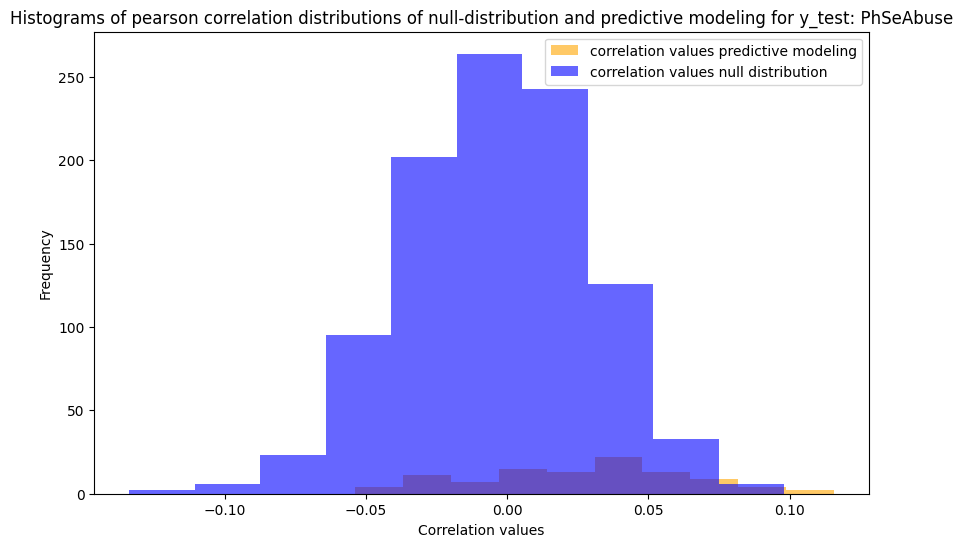

y_test: NeighborhoodThreat


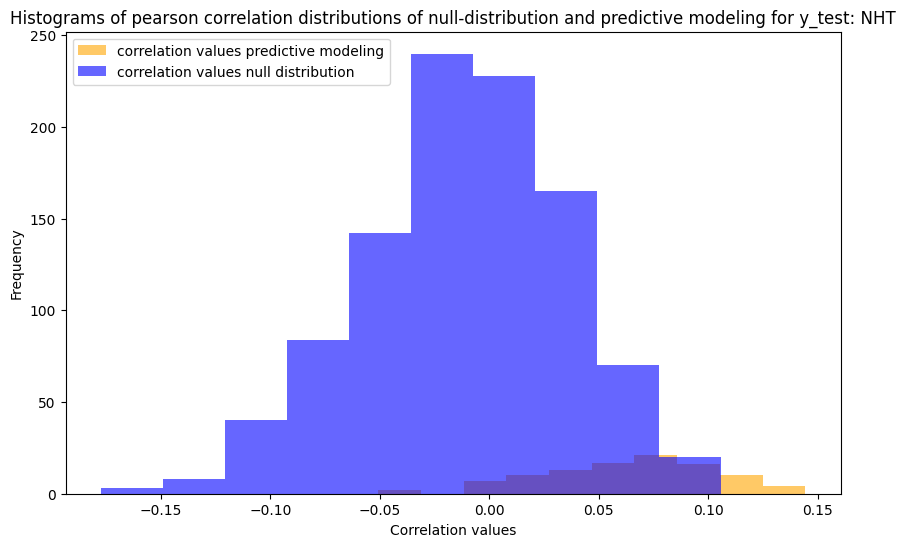

y_test: HouseholdDysfunction


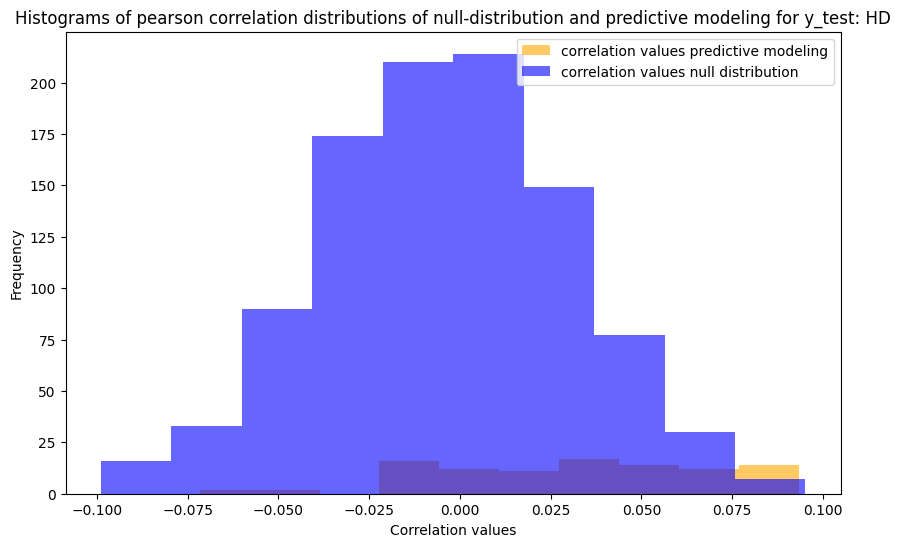

y_test: flipped_income


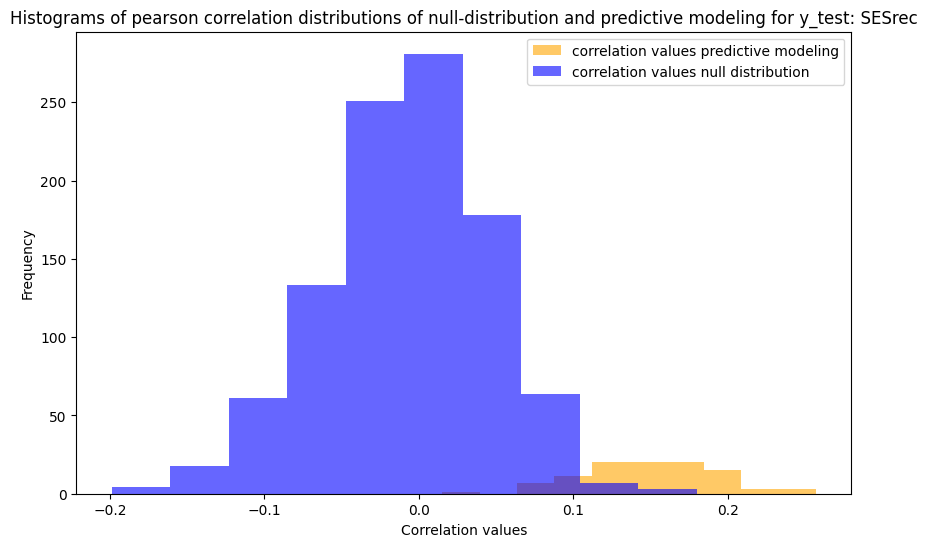

In [19]:
# Create Plot for Pearson correlation values:

for nr_iteration in range(n_y_applied):
    print ("y_test: %s" % y_applied.columns[nr_iteration])
    current_y_test = y_applied_datanames[nr_iteration]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    plt.hist(corr_coeff_predictive_modeling_pearson.iloc[nr_iteration], color='orange', alpha=0.6, label='correlation values predictive modeling')

    plt.hist(corr_coeff_null_distribution_pearson.iloc[nr_iteration], color='blue', alpha=0.6, label='correlation values null distribution')

    # title and axis labeling
    plt.xlabel('Correlation values')
    plt.ylabel('Frequency')
    plt.title(f"Histograms of pearson correlation distributions of null-distribution and predictive modeling for y_test: {current_y_test}")
    plt.legend()

    # save plot:
    path_2_plot = os.path.join(full_path, f"corr_plot_pred_modeling_null_distribution_pearson_corrrelation{shuffling_type}_y_test_{current_y_test}.png")
    plt.savefig(path_2_plot)

    # Show plot
    plt.show()

In [20]:
#after running, do FDR correction for number of tests

import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.multicomp import multipletests

def correct_p_values_and_get_significant_after_correction(original_p, method='fdr_bh'):
    """
    Corrects p-values for multiple comparisons and identifies significant values.

    Args:
        original_p (array-like): The original p-values.
        method (str, optional): The multiple comparisons correction method. 
                                 Defaults to 'fdr_bh' (Benjamini/Hochberg).

    Returns:
        pandas.DataFrame: A DataFrame with original_p, adjusted_p, and significant columns.
    """

    reject, adjusted_p, _, _ = multipletests(original_p, method=method)
    results_df = pd.DataFrame({
        'original_p': original_p,
        'adjusted_p': adjusted_p,
        'significant': reject  # Directly use the 'reject' array from multipletests
    })
    return results_df

#  p-values:
original_p_values = np.array([ 
0.322,
0.003,
0.157,
0

])
results = correct_p_values_and_get_significant_after_correction(original_p_values)
print(results)

# To get only the significant results:
significant_results = results[results['significant']]
print("\nSignificant Results:")
print(significant_results)



   original_p  adjusted_p  significant
0       0.322    0.322000        False
1       0.003    0.006000         True
2       0.157    0.209333        False
3       0.000    0.000000         True

Significant Results:
   original_p  adjusted_p  significant
1       0.003       0.006         True
3       0.000       0.000         True
